# This notebook describes the derivation of variables from the Digital Elevation Model (DEM) for the Area of Interest

In [1]:
# Import the neccessary libraries: 
import rioxarray
import dask.array as da
import xarray as xr 

from osgeo import gdal
import os
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
import numpy as np
from numpy import ma
#import richdem as rd

Setting the directory where the data is located

In [6]:
os.chdir('Q:\\5m Training Data Rasters V2\\')

Plot the DTM (DTM clipped in ArcGIS Pro)

c:\Users\Erlen\.conda\envs\ZonalStPip\Lib\site-packages\xarray\core\rolling.py:1027: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  reduced = self.obj.variable.coarsen(


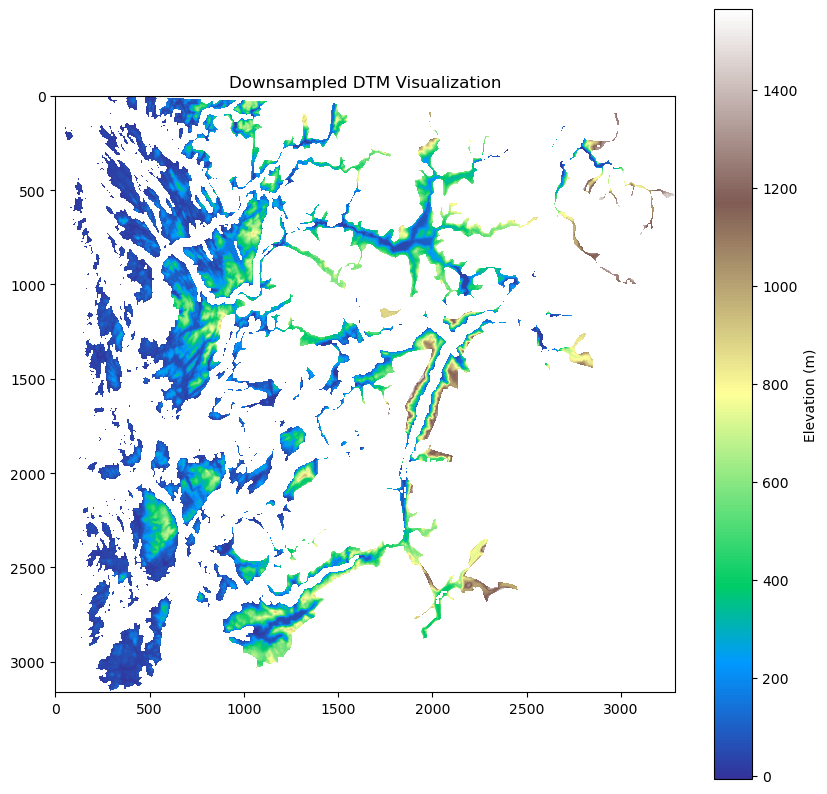

In [7]:
DTM = rasterio.open("elevation.tif")
#show(DTM, cmap='terrain')

chunk_x = 16384
chunk_y = 16384
dtm_data = rioxarray.open_rasterio(DTM, chunks={'band': 1, 'x': chunk_x, 'y': chunk_y})

# Mask out the NoData values
nodata = dtm_data.rio.nodata
dtm_data = dtm_data.where(dtm_data != nodata, other=np.nan)

# Downsample the data for visualization
# You can adjust 'factor' to a suitable value for your dataset and desired visualization resolution
factor = 10
dtm_data_coarsened = dtm_data.coarsen(x=factor, y=factor, boundary='trim').mean(skipna=True)

# Compute to get the downsampled numpy array
# The 'compute()' here triggers the actual computation
downsampled_array = dtm_data_coarsened.compute()

# Plot the data
plt.figure(figsize=(10, 10))
plt.imshow(downsampled_array[0], cmap='terrain', vmin=np.nanmin(downsampled_array), vmax=np.nanmax(downsampled_array))
plt.colorbar(label='Elevation (m)')
plt.title("Downsampled DTM Visualization")
plt.show()

In [4]:
DTM.nodatavals

(-3.4028234663852886e+38,)

In [5]:
DTM.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 18002,
 'height': 9002,
 'count': 1,
 'crs': CRS.from_wkt('LOCAL_CS["ETRS89 / UTM zone 33N",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(5.0, 0.0, -39575.0,
        0.0, -5.0, 6861005.0)}

Inspecting the distribution of values to check for errors and anomalies in the data (Using 'rioxarray' and 'dask' for chunking the large DTM)

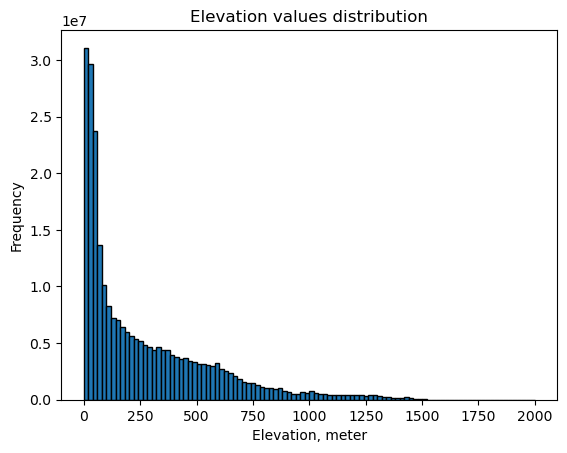

In [4]:
# Read the raster file with rioxarray, chunking with dask

chunk_x = 8192
chunk_y = 8192

dtm_data = rioxarray.open_rasterio(DTM, chunks={'band': 1, 'x': chunk_x, 'y': chunk_y})

# Define the range for the histogram and bin edges
elevation_range = [0, 2000]  # Adjust this based on your data
bin_edges = np.linspace(elevation_range[0], elevation_range[1], 101)  # 100 bins

histogram = da.histogram(dtm_data.data, bins=bin_edges)[0]

hist = histogram.compute()

fig, axhist = plt.subplots()
axhist.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", align="edge")
axhist.set_title("Elevation values distribution")
axhist.set_xlabel('Elevation, meter')
axhist.set_ylabel('Frequency')
plt.show()

# Aspect - Northerness and Easterness

Aspect is a circular land surface parameter. The difference between 1 and 360 is only one unit. That's why it makes sense to decompose aspect into its sine and cosine components representing the exposedness of the slopes to east and north with values varying between -1 and 1, so that Machine Learning would not assign more importance to 360 than to 1

In [ ]:
chunk_x = 8192
chunk_y = 8192
src = rioxarray.open_rasterio(
    "aspect.tif", 
    chunks={'band': 1, 'x': chunk_x, 'y': chunk_y}
)
aspect = src.sel(band=1)
nodata_val = -9999

# Apply the mask, considering NoData values explicitly
aspect_masked = aspect.where(aspect != nodata_val)

Converting degrees to radians

In [21]:
aspect = src.sel(band=1)

# Apply the mask and compute the minimum value using Dask
aspect_masked = aspect.where(aspect >= 0)
min_value = aspect_masked.min().compute()
print(min_value)

<xarray.DataArray ()>
array(0., dtype=float32)
Coordinates:
    band         int32 1
    spatial_ref  int32 0


In [22]:
# Convert aspect from degrees to radians using Dask's function
aspect_rad = da.radians(aspect_masked.data)

Decomposing aspect as radians into it`s cosine to visualize the northerness of the slope 

In [23]:
aspect_northerness = da.cos(aspect_rad)

Saving the output as .tif file

In [24]:
src_ds = gdal.Open("aspect.tif")

# Create a new raster for output
drv = gdal.GetDriverByName('GTiff')
outRaster = drv.Create('northerness.tif', src_ds.RasterXSize, src_ds.RasterYSize, 1, gdal.GDT_Float32)
outRaster.SetGeoTransform(src_ds.GetGeoTransform())
outRaster.SetProjection(src_ds.GetProjection())

# Get the raster band to write to
outBand = outRaster.GetRasterBand(1)

# Define your chunk size
chunk_size = 16384

# Process the Dask array in chunks
for y in range(0, aspect_northerness.shape[0], chunk_size):
    for x in range(0, aspect_northerness.shape[1], chunk_size):
        # Compute each chunk to a numpy array
        chunk_data = aspect_northerness[y:y+chunk_size, x:x+chunk_size].compute()

        # Write this chunk to the raster
        outBand.WriteArray(chunk_data, xoff=x, yoff=y)

# Clean up
outBand.FlushCache()
outRaster = None
src_ds = None

Set 'nodata' to 'nan'

In [25]:
spi_ds = gdal.Open('northerness.tif', 1)  # Open the file in editable mode
spi_band = spi_ds.GetRasterBand(1)
spi_band.SetNoDataValue(nodata_val)  # Set NoData value to nan
spi_band = None
spi_ds = None

Decomposing aspect as radians into it`s sine to visualize the easterness of the slope 

In [26]:
aspect_eastness = da.sin(aspect_rad)

In [27]:
src_ds = gdal.Open("aspect.tif")

# Create a new raster for output
drv = gdal.GetDriverByName('GTiff')
outRaster = drv.Create('eastness.tif', src_ds.RasterXSize, src_ds.RasterYSize, 1, gdal.GDT_Float32)
outRaster.SetGeoTransform(src_ds.GetGeoTransform())
outRaster.SetProjection(src_ds.GetProjection())

# Get the raster band to write to
outBand = outRaster.GetRasterBand(1)

# Define your chunk size
chunk_size = 16384

# Process the Dask array in chunks
for y in range(0, aspect_eastness.shape[0], chunk_size):
    for x in range(0, aspect_eastness.shape[1], chunk_size):
        # Compute each chunk to a numpy array
        chunk_data = aspect_eastness[y:y+chunk_size, x:x+chunk_size].compute()

        # Write this chunk to the raster
        outBand.WriteArray(chunk_data, xoff=x, yoff=y)

# Clean up
outBand.FlushCache()
outRaster = None
src_ds = None
aspect= None

Set 'nodata' to 'nan'

In [28]:
spi_ds = gdal.Open('eastness.tif', 1)  # Open the file in editable mode
spi_band = spi_ds.GetRasterBand(1)
spi_band.SetNoDataValue(nodata_val)  # Set NoData value to nan
spi_band = None
spi_ds = None

Plan and profile curvature

In [3]:
import richdem as rd

RichDEM is a set of digital elevation model (DEM) hydrologic analysis tools. RichDEM uses parallel processing and state of the art algorithms to quickly process even very large DEMs (Barnes, Richard. 2016). RichDEM: Terrain Analysis Software. http://github.com/r-barnes/richdem and https://richdem.readthedocs.io/en/latest/intro.html

In [4]:
def calculate_profile_curvature(dem_block):
    dem_rd = rd.rdarray(dem_block, no_data=-3.4028234663852886e+38)
    profile_curvature = rd.TerrainAttribute(dem_rd, attrib='profile_curvature')
    return profile_curvature

# Load the DEM file
dem_ds = gdal.Open("elevation.tif")

# Get dimensions and geotransform from the DEM dataset
x_size = dem_ds.RasterXSize
y_size = dem_ds.RasterYSize
geotransform = dem_ds.GetGeoTransform()
projection = dem_ds.GetProjection()

# Create a new dataset for profile curvature output
driver = gdal.GetDriverByName('GTiff')
profile_curvature_ds = driver.Create('profile_curvature.tif', x_size, y_size, 1, gdal.GDT_Float32)
profile_curvature_ds.SetGeoTransform(geotransform)
profile_curvature_ds.SetProjection(projection)

# Define block size
block_size = 40000  # Adjust as needed 

# Loop over the DEM raster in blocks
for x in range(0, x_size, block_size):
    for y in range(0, y_size, block_size):
        x_block_size = min(block_size, x_size - x)
        y_block_size = min(block_size, y_size - y)

        dem_block = dem_ds.GetRasterBand(1).ReadAsArray(x, y, x_block_size, y_block_size)
        profile_curvature_block = calculate_profile_curvature(dem_block)
        profile_curvature_ds.GetRasterBand(1).WriteArray(profile_curvature_block, x, y)
# Close the datasets
dem_ds = None
profile_curvature_ds = None

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


# Computing TPI (Topographic Position Index)

TPI stands for Topographic Position Index, which is defined as the difference between a central pixel and the mean of its surrounding cells (see Wilson et al 2007, Marine Geodesy 30:3-35)

Define the DEM:

In [8]:
dem = gdal.Open("elevation.tif")

Calculating Topographic Position Index with gdaldem. This command outputs a single-band raster with values computed from the elevation. Description of GDAL DEM utility can be seen on https://gdal.org/programs/gdaldem.html

In [11]:
tpi = gdal.DEMProcessing("TPI.tif", dem, 'TPI', computeEdges=True)

Define projection of the TPI raster

In [12]:
tpi = None

Plotting TPI data and value histogram

In [ ]:
TPI = rasterio.open("TPI.tif")

# Define chunk sizes for processing large rasters (Change according to computer hardware)
chunk_x = 16384
chunk_y = 16384

tpi_data = rioxarray.open_rasterio(TPI, chunks={'band': 1, 'x': chunk_x, 'y': chunk_y})
# Mask out the NoData values, replace -9999 with the actual NoData value of your TPI raster
nodata = tpi_data.rio.nodata
tpi_data = tpi_data.where(tpi_data != nodata, other=np.nan)


factor = 10
tpi_data_coarsened = tpi_data.coarsen(x=factor, y=factor, boundary='trim').mean(skipna=True)

downsampled_array = tpi_data_coarsened.compute()
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Topographic Position Index", fontsize=20)
cmap = plt.get_cmap('terrain')

# Exclude NoData values from the color scale by setting 'vmin' and 'vmax'
# Adjust these as per the actual range of your TPI data
vmin, vmax = np.nanmin(downsampled_array), np.nanmax(downsampled_array)
ax.imshow(downsampled_array[0], cmap=cmap, vmin=vmin, vmax=vmax)


fig.colorbar(colors.ScalarMappable(norm=colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), ax=ax)

plt.savefig('Q:\\DEM_Variables\\DEM_Variables_PNG\\TPI.png', bbox_inches='tight')
plt.show()


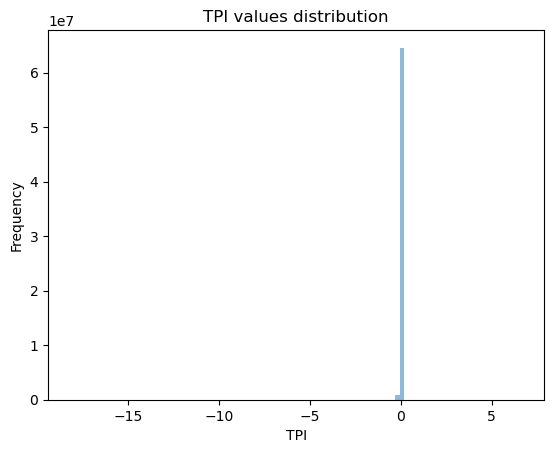

In [5]:
data_values = downsampled_array.values.flatten()

# Remove nan values for histogram computation
data_values = data_values[~np.isnan(data_values)]

# Plot the histogram
fig, axhist = plt.subplots()
axhist.hist(data_values, bins=100, alpha=0.5)
axhist.set_title("TPI values distribution")
axhist.set_xlabel('TPI')
axhist.set_ylabel('Frequency')

plt.show()

# TRI (Topographic Ruggedness Index)

This command outputs a single-band raster with values computed from the elevation. TRI stands for Terrain Ruggedness Index, which measures the difference between a central pixel and its surrounding cells. (see Riley, S.J., De Gloria, S.D., Elliot, R. (1999): A Terrain Ruggedness that Quantifies Topographic Heterogeneity. Intermountain Journal of Science, Vol.5, No.1-4, pp.23-27). TRI is computed as the square root of the sum of the square of the difference between a central pixel and its surrounding cells

In [ ]:
tri = gdal.DEMProcessing("TRI.tif", dem, 'TRI', computeEdges=True)

In [15]:
tri = None

Plotting the distribution

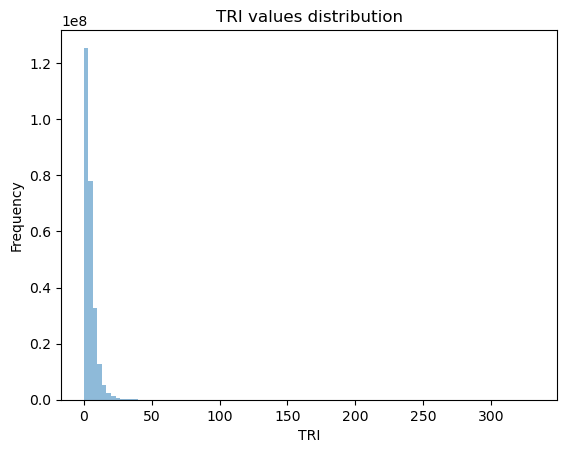

In [9]:
src = rasterio.open("TRI.tif")

# Define chunk sizes defined by system specs
chunk_x = 16384
chunk_y = 16384

data = rioxarray.open_rasterio(src, chunks={'band': 1, 'x': chunk_x, 'y': chunk_y})
nodata = data.rio.nodata
data = data.where(data != nodata, other=np.nan)
data_array = data.compute()
data_values = data_array.values.flatten()
data_values = data_values[~np.isnan(data_values)]

# Plot the histogram
fig, axhist = plt.subplots()
axhist.hist(data_values, bins=100, alpha=0.5)
axhist.set_title("TRI values distribution")
axhist.set_xlabel('TRI')
axhist.set_ylabel('Frequency')

plt.show()

# Stream power Index

The Stream Power Index (SPI) is a measure of the erosive power of flowing water. SPI is calculated based upon slope and contributing area (flow accumulation)

In [16]:
def calculate_spi(flow_acc_block, slope_block):
    return np.log((flow_acc_block*1*1 + 0.001) * np.tan(slope_block + 0.001))

# Open the raster files
flow_acc_ds = gdal.Open("FlowAcc.tif") # Flow acumulation generated using ArcGIS Pro software
slope_rad_ds = gdal.Open("Slope_Radians.tif") # Slope in radians is generated using ArcPy

# Assuming both datasets have the same dimensions and geotransform
x_size = flow_acc_ds.RasterXSize
y_size = flow_acc_ds.RasterYSize
geotransform = flow_acc_ds.GetGeoTransform()
projection = flow_acc_ds.GetProjection()

# Create a new dataset for SPI output
driver = gdal.GetDriverByName('GTiff')
spi_ds = driver.Create('SPI.tif', x_size, y_size, 1, gdal.GDT_Float32)
spi_ds.SetGeoTransform(geotransform)
spi_ds.SetProjection(projection)

# Define block size
block_size = 38000  # Adjust as needed 

# Loop over the raster in blocks
for x in range(0, x_size, block_size):
    for y in range(0, y_size, block_size):
        x_block_size = min(block_size, x_size - x)
        y_block_size = min(block_size, y_size - y)

        flow_acc_block = flow_acc_ds.GetRasterBand(1).ReadAsArray(x, y, x_block_size, y_block_size)
        slope_block = slope_rad_ds.GetRasterBand(1).ReadAsArray(x, y, x_block_size, y_block_size)
        spi_block = calculate_spi(flow_acc_block, slope_block)
        spi_ds.GetRasterBand(1).WriteArray(spi_block, x, y)

# Set nodata value to 'non', recognised by ArcGIS Pro as "NoData":
spi_ds = gdal.Open('SPI.tif', 1)  # Open the file in editable mode
spi_band = spi_ds.GetRasterBand(1)
spi_band.SetNoDataValue(float('nan'))  # Set NoData value to nan
spi_band = None
spi_ds = None

# Close the datasets
flow_acc_ds = None
slope_rad_ds = None
spi_ds = None

Roughness

Outputs a single-band raster with values computed from the elevation. Roughness is the measure of irregularity of the surface. It’s calculated by the largest inter-cell difference of a central pixel and its sourrounding cell

In [5]:
dem = gdal.Open("Q:\\5m Training Data Rasters V2\\elevation.tif")

In [ ]:
roughness = gdal.DEMProcessing("roughness.tif", dem, 'roughness', computeEdges=True)
roughness = None